[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/satya-thirumani/Python/blob/master/AnalyticsVidhya%20Janata%20Hackathon/Analytics%20Vidhya%20JanataHack.ipynb)

# Analytics Vidhya - JanataHack (Janata Hackathon)

---



## https://satya-python.blogspot.com/

###  To predict gender of e-commerce’s participants from their product viewing records.

#### April 2020

In [1]:
# Importing required packages

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.options.display.max_colwidth = 100

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from tqdm import tqdm
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler,PolynomialFeatures,QuantileTransformer,PowerTransformer
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Data

In [2]:
# For Google Colaboratory and Google Drive
from google.colab import files,drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/'Analytics Vidhya'/JanataHack

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Analytics Vidhya/JanataHack


In [3]:
ls -tlr

total 1627
-rw------- 1 root root 1138290 Apr 10 08:23 train.csv
-rw------- 1 root root  465312 Apr 10 08:23 test.csv
-rw------- 1 root root   61832 Apr 12 16:26 submission.csv


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["session_id"]

# EDA - Exploratory Data Analysis

In [5]:
# Check number of features and data points in train and test
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 10500
Number of features in train: 5
Number of data points in test: 4500
Number of features in test: 4


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   session_id   10500 non-null  object
 1   startTime    10500 non-null  object
 2   endTime      10500 non-null  object
 3   ProductList  10500 non-null  object
 4   gender       10500 non-null  object
dtypes: object(5)
memory usage: 410.3+ KB


In [7]:
train.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00006/D02554/;A00002/B00003/C00006/D28436/;A00002/B0...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00031/D02617/;A00001/B00009/C00031/D29407/;A00001/B0...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00018/D10285/;A00002/B00004/C00018/D10286/,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00012/D30806/,male


In [8]:
test.head()

,session_id,startTime,endTime,ProductList
0,u12112,08/12/14 13:36,08/12/14 13:36,A00002/B00003/C00006/D19956/
1,u19725,19/12/14 13:52,19/12/14 13:52,A00002/B00005/C00067/D02026/
2,u11795,01/12/14 10:44,01/12/14 10:44,A00002/B00002/C00004/D12538/
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002/B00003/C00079/D22781/;A00002/B00003/C00079/D22782/;A00002/B00003/C00079/D19325/;A00002/B0...
4,u18034,15/12/14 19:33,15/12/14 19:33,A00002/B00001/C00010/D23419/


In [0]:
train['startTime'] = pd.to_datetime(train['startTime'], format='%d/%m/%y %H:%M')
test['startTime'] = pd.to_datetime(test['startTime'], format='%d/%m/%y %H:%M')
train['endTime'] = pd.to_datetime(train['endTime'], format='%d/%m/%y %H:%M')
test['endTime'] = pd.to_datetime(test['endTime'], format='%d/%m/%y %H:%M')

In [10]:
train.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00006/D02554/;A00002/B00003/C00006/D28436/;A00002/B0...,female
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/;A00001/B00009/C00031/D02617/;A00001/B00009/C00031/D29407/;A00001/B0...,male
2,u19037,2014-12-01 15:58:00,2014-12-01 15:58:00,A00002/B00001/C00020/D16944/,female
3,u14556,2014-11-23 02:57:00,2014-11-23 03:00:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00018/D10285/;A00002/B00004/C00018/D10286/,female
4,u24295,2014-12-17 16:44:00,2014-12-17 16:46:00,A00001/B00001/C00012/D30805/;A00001/B00001/C00012/D30806/,male


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   session_id   4500 non-null   object        
 1   startTime    4500 non-null   datetime64[ns]
 2   endTime      4500 non-null   datetime64[ns]
 3   ProductList  4500 non-null   object        
dtypes: datetime64[ns](2), object(2)
memory usage: 140.8+ KB


In [12]:
train.nunique()

session_id     10500
startTime       8815
endTime         8803
ProductList     9402
gender             2
dtype: int64

In [13]:
# Checking for NULL/missing values
train.isnull().sum().sort_values(ascending=False).nlargest(20)

gender         0
ProductList    0
endTime        0
startTime      0
session_id     0
dtype: int64

In [14]:
# Checking for NULL/missing values
test.isnull().sum().sort_values(ascending=False).nlargest(20)

ProductList    0
endTime        0
startTime      0
session_id     0
dtype: int64

female    8192
male      2308
Name: gender, dtype: int64

female    78.019048
male      21.980952
Name: gender, dtype: float64



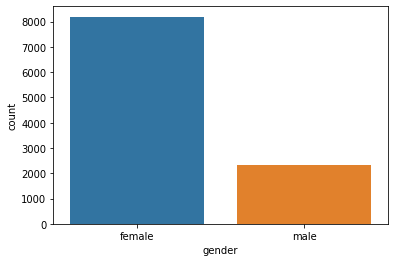

In [15]:
print(train['gender'].value_counts())
print()
print(train['gender'].value_counts(normalize=True)*100)
print()
sns.countplot(train["gender"])

# Preparing Data

In [16]:
train.sample(5)

,session_id,startTime,endTime,ProductList,gender
5051,u16700,2014-12-18 16:11:00,2014-12-18 16:12:00,A00002/B00002/C00011/D31935/;A00002/B00002/C00002/D17770/,female
6155,u22127,2014-12-07 18:21:00,2014-12-07 18:22:00,A00002/B00003/C00014/D00738/;A00001/B00001/C00019/D05339/,male
10190,u13273,2014-12-08 19:05:00,2014-12-08 19:05:00,A00002/B00005/C00057/D05868/,male
2408,u24697,2014-12-19 16:06:00,2014-12-19 16:09:00,A00002/B00002/C00004/D25751/;A00002/B00002/C00004/D07128/;A00002/B00002/C00004/D08384/;A00002/B0...,female
251,u17761,2014-11-29 20:11:00,2014-11-29 20:14:00,A00002/B00002/C00002/D00976/;A00002/B00002/C00002/D00550/;A00002/B00002/C00002/D06058/;A00002/B0...,female


In [17]:
test.sample(5)

,session_id,startTime,endTime,ProductList
888,u18676,2014-12-02 10:24:00,2014-12-02 10:27:00,A00002/B00007/C00021/D17754/;A00002/B00007/C00021/D12122/;A00002/B00007/C00021/D17766/;A00002/B0...
2122,u17616,2014-12-06 17:22:00,2014-12-06 21:36:00,A00002/B00002/C00002/D20132/;A00002/B00002/C00002/D00499/;A00002/B00002/C00002/D20364/;A00002/B0...
3941,u19882,2014-11-29 20:48:00,2014-11-29 20:48:00,A00005/B00032/C00094/D01681/
1321,u15153,2014-11-27 09:31:00,2014-11-27 09:33:00,A00002/B00017/C00045/D13762/;A00002/B00017/C00045/D00137/;A00002/B00002/C00007/D03929/
1631,u12979,2014-12-05 19:16:00,2014-12-05 19:16:00,A00001/B00037/C00135/D18404/


In [0]:
train['startTime_year'] = train['startTime'].dt.year
train['startTime_month'] = train['startTime'].dt.month
train['startTime_day'] = train['startTime'].dt.day
train['startTime_hour'] = train['startTime'].dt.hour
train['startTime_min'] = train['startTime'].dt.minute
train['startTime_quarter'] = train['startTime'].dt.quarter
train['startTime_Dayofweek'] = train['startTime'].dt.dayofweek
train['startTime_Dayweek'] = train['startTime'].dt.day_name()
train['startTime_is_weekend'] = np.where(train['startTime'].dt.dayofweek.isin(['Sunday', 'Saturday']), 1,0)
train['duration'] = round((train['endTime'] - train['startTime'])/timedelta(minutes=1),0)

test['startTime_year'] = test['startTime'].dt.year
test['startTime_month'] = test['startTime'].dt.month
test['startTime_day'] = test['startTime'].dt.day
test['startTime_hour'] = test['startTime'].dt.hour
test['startTime_min'] = test['startTime'].dt.minute
test['startTime_quarter'] = test['startTime'].dt.quarter
test['startTime_Dayofweek'] = test['startTime'].dt.dayofweek
test['startTime_Dayweek'] = test['startTime'].dt.day_name()
test['startTime_is_weekend'] = np.where(test['startTime'].dt.dayofweek.isin(['Sunday', 'Saturday']), 1,0)
test['duration'] = round((test['endTime'] - test['startTime'])/timedelta(minutes=1),0)

In [0]:
train['duration'] = train['duration'].astype('int64')
test['duration'] = test['duration'].astype('int64')

In [20]:
train.head(5)

,session_id,startTime,endTime,ProductList,gender,startTime_year,startTime_month,startTime_day,startTime_hour,startTime_min,startTime_quarter,startTime_Dayofweek,startTime_Dayweek,startTime_is_weekend,duration
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00006/D02554/;A00002/B00003/C00006/D28436/;A00002/B0...,female,2014,12,15,18,11,4,0,Monday,0,1
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/;A00001/B00009/C00031/D02617/;A00001/B00009/C00031/D29407/;A00001/B0...,male,2014,12,16,14,35,4,1,Tuesday,0,6
2,u19037,2014-12-01 15:58:00,2014-12-01 15:58:00,A00002/B00001/C00020/D16944/,female,2014,12,1,15,58,4,0,Monday,0,0
3,u14556,2014-11-23 02:57:00,2014-11-23 03:00:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00018/D10285/;A00002/B00004/C00018/D10286/,female,2014,11,23,2,57,4,6,Sunday,0,3
4,u24295,2014-12-17 16:44:00,2014-12-17 16:46:00,A00001/B00001/C00012/D30805/;A00001/B00001/C00012/D30806/,male,2014,12,17,16,44,4,2,Wednesday,0,2


In [0]:
# products=pd.DataFrame([ x.split(';') for x in train['ProductList'].tolist() ])[0]
# train['category'] = pd.DataFrame([x.split('/') for x in products.tolist()])[0]
# train['sub_category'] = pd.DataFrame([x.split('/') for x in products.tolist()])[1]
# train['sub_sub_category'] = pd.DataFrame([x.split('/') for x in products.tolist()])[2]
# train['product'] = pd.DataFrame([x.split('/') for x in products.tolist()])[3]

train['unique_categories'] = train['ProductList'].apply(lambda x: list(set(re.findall(r'A[0-9]+',x)))).apply(';'.join)
train['unique_sub_categories'] = train['ProductList'].apply(lambda x: list(set(re.findall(r'B[0-9]+',x)))).apply(';'.join)
train['unique_sub_sub_categories'] = train['ProductList'].apply(lambda x: list(set(re.findall(r'C[0-9]+',x)))).apply(';'.join)
train['unique_products'] = train['ProductList'].apply(lambda x: list(set(re.findall(r'D[0-9]+',x)))).apply(';'.join)

In [0]:
# products=pd.DataFrame([ x.split(';') for x in test['ProductList'].tolist() ])[0]
# test['category'] = pd.DataFrame([x.split('/') for x in products.tolist()])[0]
# test['sub_category'] = pd.DataFrame([x.split('/') for x in products.tolist()])[1]
# test['sub_sub_category'] = pd.DataFrame([x.split('/') for x in products.tolist()])[2]
# test['product'] = pd.DataFrame([x.split('/') for x in products.tolist()])[3]

test['unique_categories'] = test['ProductList'].apply(lambda x: list(set(re.findall(r'A[0-9]+',x)))).apply(';'.join)
test['unique_sub_categories'] = test['ProductList'].apply(lambda x: list(set(re.findall(r'B[0-9]+',x)))).apply(';'.join)
test['unique_sub_sub_categories'] = test['ProductList'].apply(lambda x: list(set(re.findall(r'C[0-9]+',x)))).apply(';'.join)
test['unique_products'] = test['ProductList'].apply(lambda x: list(set(re.findall(r'D[0-9]+',x)))).apply(';'.join)

In [0]:
train['num_product']  = train['ProductList'].apply(lambda s : s.count(';')+1)
test['num_product']  = test['ProductList'].apply(lambda s : s.count(';')+1)

In [24]:
train.tail()

,session_id,startTime,endTime,ProductList,gender,startTime_year,startTime_month,startTime_day,startTime_hour,startTime_min,startTime_quarter,startTime_Dayofweek,startTime_Dayweek,startTime_is_weekend,duration,unique_categories,unique_sub_categories,unique_sub_sub_categories,unique_products,num_product
10495,u15442,2014-11-18 07:39:00,2014-11-18 07:42:00,A00002/B00002/C00007/D06407/;A00002/B00002/C00007/D06409/,female,2014,11,18,7,39,4,1,Tuesday,0,3,A00002,B00002,C00007,D06409;D06407,2
10496,u17986,2014-11-25 15:16:00,2014-11-25 15:16:00,A00006/B00030/C00334/D11660/,female,2014,11,25,15,16,4,1,Tuesday,0,0,A00006,B00030,C00334,D11660,1
10497,u22508,2014-12-09 10:11:00,2014-12-09 10:11:00,A00002/B00002/C00007/D18028/,female,2014,12,9,10,11,4,1,Tuesday,0,0,A00002,B00002,C00007,D18028,1
10498,u17087,2014-11-22 11:27:00,2014-11-22 11:27:00,A00003/B00012/C00131/D09453/;A00003/B00012/C00073/D09454/,female,2014,11,22,11,27,4,5,Saturday,0,0,A00003,B00012,C00131;C00073,D09454;D09453,2
10499,u23137,2014-12-19 03:11:00,2014-12-19 03:19:00,A00002/B00001/C00010/D02309/;A00002/B00002/C00002/D32450/;A00002/B00001/C00059/D21254/;A00003/B0...,female,2014,12,19,3,11,4,4,Friday,0,8,A00002;A00003,B00002;B00004;B00001,C00059;C00010;C00002;C00089,D02309;D18619;D32450;D21254,4


In [25]:
# Unique Categories
train.unique_categories.value_counts().sort_index()

A00001                  1482
A00001;A00002;A00004       1
A00001;A00003             12
A00001;A00004              2
A00001;A00005              9
A00001;A00010              8
A00002                  6559
A00002;A00001            134
A00002;A00001;A00003       1
A00002;A00003            129
A00002;A00004              5
A00002;A00004;A00003       2
A00002;A00004;A00005       2
A00002;A00005             32
A00002;A00005;A00003       1
A00002;A00005;A00010       1
A00002;A00010              2
A00003                  1502
A00004                   130
A00004;A00001              2
A00004;A00002;A00001       1
A00004;A00003              1
A00005                   182
A00005;A00003              1
A00006                    95
A00006;A00001              5
A00006;A00002             14
A00006;A00003              1
A00006;A00005              2
A00006;A00007;A00002       1
A00006;A00010              1
A00007                    25
A00007;A00001              1
A00007;A00003              1
A00007;A00004 

In [26]:
# Unique Products
train['unique_products'].value_counts().sort_values(ascending=False)

D00266                  25
D20430                  23
D00232                  19
D19326                  19
D21690                  18
                        ..
D20324                   1
D15989;D00034            1
D12276;D12278;D12279     1
D04665                   1
D12538                   1
Name: unique_products, Length: 9384, dtype: int64

In [0]:
target = train["gender"]
train = train.drop(['gender','session_id','startTime','endTime','ProductList'], axis=1)
test = test.drop(['session_id','startTime','endTime','ProductList'], axis=1)

In [0]:
data = pd.concat([train, test])

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   startTime_year             15000 non-null  int64 
 1   startTime_month            15000 non-null  int64 
 2   startTime_day              15000 non-null  int64 
 3   startTime_hour             15000 non-null  int64 
 4   startTime_min              15000 non-null  int64 
 5   startTime_quarter          15000 non-null  int64 
 6   startTime_Dayofweek        15000 non-null  int64 
 7   startTime_Dayweek          15000 non-null  object
 8   startTime_is_weekend       15000 non-null  int64 
 9   duration                   15000 non-null  int64 
 10  unique_categories          15000 non-null  object
 11  unique_sub_categories      15000 non-null  object
 12  unique_sub_sub_categories  15000 non-null  object
 13  unique_products            15000 non-null  object
 14  num_pro

In [30]:
data.head(10)

,startTime_year,startTime_month,startTime_day,startTime_hour,startTime_min,startTime_quarter,startTime_Dayofweek,startTime_Dayweek,startTime_is_weekend,duration,unique_categories,unique_sub_categories,unique_sub_sub_categories,unique_products,num_product
0,2014,12,15,18,11,4,0,Monday,0,1,A00002,B00003,C00006,D28437;D28435;D02554;D28436,4
1,2014,12,16,14,35,4,1,Tuesday,0,6,A00001,B00009,C00031,D25444;D29404;D29410;D29418;D29411;D02617;D29407,7
2,2014,12,1,15,58,4,0,Monday,0,0,A00002,B00001,C00020,D16944,1
3,2014,11,23,2,57,4,6,Sunday,0,3,A00002,B00004,C00018,D10286;D10285;D10284,3
4,2014,12,17,16,44,4,2,Wednesday,0,2,A00001,B00001,C00012,D30805;D30806,2
5,2014,12,12,15,31,4,4,Friday,0,0,A00002,B00002,C00081,D25039,1
6,2014,12,5,19,33,4,4,Friday,0,1,A00002,B00011,C00180;C00114,D18459;D18487,2
7,2014,12,9,16,2,4,1,Tuesday,0,4,A00002,B00002;B00001,C00059;C00002,D15254;D02063;D00900,3
8,2014,11,25,11,55,4,1,Tuesday,0,0,A00002,B00001,C00010,D06129,1
9,2014,12,6,16,16,4,5,Saturday,0,1,A00002,B00002;B00001,C00010;C00112,D12841;D20047,2


In [0]:
# # One Hot Encoding
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [32]:
train2.head()

,startTime_month_12,startTime_day_2,startTime_day_3,startTime_day_5,startTime_day_6,startTime_day_7,startTime_day_8,startTime_day_9,startTime_day_12,startTime_day_13,startTime_day_14,startTime_day_15,startTime_day_16,startTime_day_17,startTime_day_18,startTime_day_19,startTime_day_20,startTime_day_21,startTime_day_22,startTime_day_23,startTime_day_25,startTime_day_26,startTime_day_27,startTime_day_28,startTime_day_29,...,num_product_9,num_product_10,num_product_11,num_product_12,num_product_13,num_product_14,num_product_15,num_product_16,num_product_17,num_product_18,num_product_19,num_product_20,num_product_21,num_product_22,num_product_23,num_product_24,num_product_25,num_product_27,num_product_28,num_product_29,num_product_30,num_product_31,num_product_35,num_product_36,num_product_43
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Using SMOTE for Balancing Data
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=2020)

# from imblearn.over_sampling import ADASYN
# sm = ADASYN()

# from imblearn.over_sampling import SVMSMOTE
# sm = SVMSMOTE(random_state=2020)

# from imblearn.combine import SMOTETomek
# sm = SMOTETomek(ratio='auto')

# from imblearn.combine import SMOTEENN
# sm = SMOTEENN(random_state=2020)

# train2, target = sm.fit_sample(train2, target.ravel())

# from collections import Counter
# print('Resampled dataset shape %s' % Counter(target))

# from imblearn.under_sampling import NearMiss
# nr = NearMiss()
# train2, target = nr.fit_sample(train2, target.ravel())
# np.bincount(target)

In [34]:
print(train2.shape, target.shape)

# (10500, 11842) (10500,)

(10500, 16374) (10500,)


In [0]:
# Scaling Data
scaler = StandardScaler()
#scaler = MinMaxScaler()
train2 = scaler.fit_transform(train2)
test = scaler.transform(test)

In [36]:
poly = PolynomialFeatures(degree=1)
train2 = poly.fit_transform(train2)
test = poly.transform(test)
poly
print("train2 shape:", train2.shape)

# train2 shape: (10500, 11843)

train2 shape: (10500, 16375)


In [0]:
# pca = PCA(random_state=2020)
# #pca = PCA(random_state=2020, n_components=5000)
# train2 = pca.fit_transform(train2)
# test = pca.transform(test)
# pca

In [38]:
train2

array([[ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       ...,
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        , -1.27475488, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ]])

In [39]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2020)
print(x_train.shape, x_val.shape)

#(7350, 11843) (3150, 11843)

(7350, 16375) (3150, 16375)


In [40]:
x_train

array([[ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        , -1.27475488, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       ...,
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        , -1.27475488, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        , -1.27475488, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ]])

In [41]:
x_val

array([[ 1.        , -1.27475488, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       ...,
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ],
       [ 1.        ,  0.78446454, -0.11582613, ..., -0.00975947,
        -0.01380263,  0.        ]])

In [42]:
y_train

6779    female
6349    female
3795    female
6600    female
5165      male
         ...  
3655    female
1661    female
2139    female
7491    female
9056      male
Name: gender, Length: 7350, dtype: object

In [43]:
y_val

222      female
2995     female
7157       male
8048     female
2340       male
          ...  
4689     female
1200     female
10247    female
6826     female
3424       male
Name: gender, Length: 3150, dtype: object

# Machine Learning Algorithms

# Logistic Regression

In [0]:
# # Logistic Regression
# #for c in [1, 10, 100, 500, 1000]:
# for c in [0.0001, 0.001, 0.01, 0.1, 1]:
#     lr = LogisticRegression(random_state=2020, C=c).fit(x_train, y_train)
#     print ("Accuracy score for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(x_val))*100))

# # Accuracy score for C=0.0001: 78.28571428571428
# # Accuracy score for C=0.001: 82.44444444444444
# # Accuracy score for C=0.01: 83.58730158730158
# # Accuracy score for C=0.1: 83.52380952380952
# # Accuracy score for C=1: 84.28571428571429

In [0]:
# clf_log = LogisticRegression(random_state=2020, C=1).fit(x_train, y_train)
# #clf_log = LogisticRegression(random_state=2020, C=0.100, solver='liblinear', max_iter=500, tol=0.000001).fit(x_train, y_train)
# y_pred_val = clf_log.predict(x_val)
# print(accuracy_score(y_val, y_pred_val)*100)
# # 78.12698412698413

In [0]:
# grid = {"C":np.logspace(1,4,5), "penalty":["l2"], "tol":np.logspace(1,4,5), "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],'max_iter':[300]}
# logreg_cv = GridSearchCV(LogisticRegression(), grid, cv=10)
# logreg_cv.fit(x_train, y_train)
# y_pred_val = logreg_cv.predict(x_val)

In [0]:
# print(logreg_cv.best_estimator_)
# print(logreg_cv.best_params_)
# print(logreg_cv.best_score_)
# LogisticRegression(C=316.22776601683796, class_weight=None, dual=False,
#                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                    max_iter=300, multi_class='auto', n_jobs=None, penalty='l2',
#                    random_state=None, solver='newton-cg', tol=10.0, verbose=0,
#                    warm_start=False)
# {'C': 316.22776601683796, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 10.0}
# 0.7148571428571427

In [0]:
# # Confusion Matrix
# cm = confusion_matrix(y_val, y_pred_val).T
# cm = cm.astype('float')/cm.sum(axis=0)
# ax = sns.heatmap(cm, annot=True, cmap='Blues');
# ax.set_xlabel('True Label',size=12)
# ax.set_ylabel('Predicted Label',size=12)

# # TP = 0.94, TN 0.5

In [0]:
# #clf_log.fit(train2, target)
# y_pred = clf_log.predict(test)
# y_pred

In [0]:
# submission = pd.DataFrame(data = {"session_id":test_ids, "gender":y_pred})
# submission.to_csv("submission.csv", index=False)
# print(submission['gender'].value_counts())

# Random Forest

In [51]:
# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state = 2020, verbose=1).fit(x_train, y_train)
#rf = RandomForestClassifier(n_estimators=200, random_state = 2020).fit(x_train, y_train)
rf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=1, warm_start=False)

In [52]:
y_val_pred_rf = rf.predict(x_val)
print(accuracy_score(y_val, y_val_pred_rf)*100)

# 89.23809523809524

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


87.42857142857143


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished


Text(33.0, 0.5, 'Predicted Label')

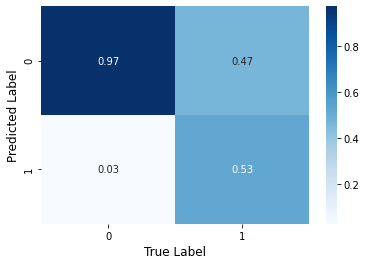

In [53]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_rf).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

# TP 0.97 TN 0.61

In [54]:
#rf.fit(train2, target)
y_pred_rf = rf.predict(test)
y_pred_rf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished


array(['female', 'female', 'female', ..., 'female', 'male', 'female'],
      dtype=object)

In [55]:
submission = pd.DataFrame(data = {"session_id":test_ids, "gender":y_pred_rf})
submission.to_csv("submission.csv", index=False)
print(submission['gender'].value_counts())

female    3903
male       597
Name: gender, dtype: int64


In [57]:
!pwd; ls -ltr
files.download('submission.csv')

/content/drive/My Drive/Analytics Vidhya/JanataHack
total 1627
-rw------- 1 root root 1138290 Apr 10 08:23 train.csv
-rw------- 1 root root  465312 Apr 10 08:23 test.csv
-rw------- 1 root root   61824 Apr 13 03:11 submission.csv


In [0]:
# from sklearn.model_selection import cross_val_score

# # Function to calculate mean absolute error
# def cross_val(x_train, y_train, model):
#     # Applying k-Fold Cross Validation
#     accuracies = cross_val_score(estimator = model, X = x_train, y = y_train, cv = 5)
#     return accuracies.mean()

# # Takes in a model, trains the model, and evaluates the model on the validation set
# def fit_and_evaluate(model):
    
#     # Train the model
#     model.fit(x_train, y_train)
    
#     # Make predictions and evalute
#     model_pred = model.predict(x_val)
#     model_cross = cross_val(x_train, y_train, model)
    
#     # Return the performance metric
#     return model_cross

# Cross Validation of all Classification Algorithms

In [0]:
# # LogisticRegression
# lg = LogisticRegression()
# lg_cross = fit_and_evaluate(lg)

# print('LogisticRegression Performance on validation set: Cross Validation Score = %0.4f' % lg_cross)

# # LogisticRegression Performance on validation set: Cross Validation Score = 0.8143

In [0]:
# # Random Forest Classification
# random = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
# random_cross = fit_and_evaluate(random)

# print('Random Forest Performance on validation set: Cross Validation Score = %0.4f' % random_cross)

# #Random Forest Performance on validation set: Cross Validation Score = 0.8697

In [0]:
# # Naive Bayes
# from sklearn.naive_bayes import GaussianNB
# naive = GaussianNB()
# naive_cross = fit_and_evaluate(naive)
# print('Naive Bayes Performance on validation set: Cross Validation Score = %0.4f' % naive_cross)
# #Naive Bayes Performance on validation set: Cross Validation Score = 0.4116

In [0]:
# # Gradiente Boosting Classification
# from xgboost import XGBClassifier
# #gb = XGBClassifier()
# gb = XGBClassifier(objective="binary:logistic", learning_rate=0.03, n_estimators=500, max_depth=1, subsample=0.4, random_state=123)
# gb_cross = fit_and_evaluate(gb)

# print('Gradiente Boosting Classification Performance on validation set: Cross Validation Score = %0.4f' % gb_cross)
# # Gradiente Boosting Classification Performance on validation set: Cross Validation Score = 0.8627

In [0]:
# # SVM
# from sklearn.svm import SVC
# svm = SVC()
# svm_cross = fit_and_evaluate(svm)

# print('SVM Performance on validation set: Cross Validation Score = %0.4f' % svm_cross)
# #SVM Performance on validation set: Cross Validation Score = 

In [0]:
# import statsmodels.api as sm
# glm = sm.GLM(np.asarray(y_train), np.asarray(x_train), sm.families.Binomial())

# results = glm.fit()

# print(roc_auc_score(y_val, results.predict(x_val)))
# #0.5567727867491301